## Part 0: get everything ready to start

In [1]:
#select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [88]:
#imports 
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix
from copy import deepcopy
from sklearn.utils import class_weight

import keras
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, GlobalAveragePooling2D, Lambda, concatenate
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10,cifar100
from tensorflow.python.keras._impl.keras.datasets.cifar import load_batch

## Part 1: establish a baseline

In [27]:
#load the CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train_orig = deepcopy(y_train)
num_classes = 10
K_train = x_train.shape[0]

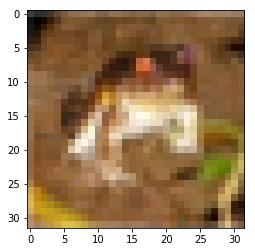

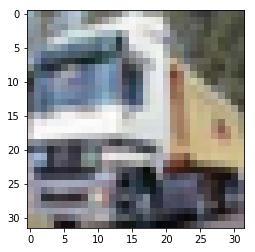

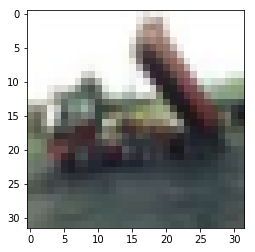

In [4]:
#visualise some examples
imgplot1 = plt.imshow(x_train[0,:,:,:])
plt.show()
imgplot2 = plt.imshow(x_train[1,:,:,:])
plt.show()
imgplot3 = plt.imshow(x_train[2,:,:,:])
plt.show()

In [28]:
# Input image dimensions and normalization
input_shape = x_train.shape[1:]

# Normalize data. This helps the exponential moving averages in keras
x_train = x_train.astype('float32')/255 #divide by 255 is done in cutout
x_test = x_test.astype('float32')/255
x_train = x_train-0.5
x_test = x_test-0.5
    
# Convert class vectors to one-hot labelled categorical matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(input_shape)

(32, 32, 3)


In [12]:
#plot function
def plot_history(history, gen=False):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(range(1, epochs+1), history.history['loss'], label='loss')
    plt.plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
    min_pos = np.argmin(history.history['val_loss'])
    min_value = history.history['val_loss'][min_pos]
    plt.scatter(min_pos+1, min_value, color='green', marker='*', label='min = ({}, {:.4f})'.format(min_pos+1, min_value))
    plt.ylabel('loss'); plt.xlabel('epoch'); plt.legend(); plt.grid()
    plt.subplot(122)
    plt.plot(range(1, epochs+1), history.history['acc'], label='acc')
    plt.plot(range(1, epochs+1), history.history['val_acc'], label='val_acc')
    max_pos = np.argmax(history.history['val_acc'])
    max_value = history.history['val_acc'][max_pos]
    plt.scatter(max_pos+1, max_value, color='green', marker='*', label='max = ({}, {:.4f})'.format(max_pos+1, max_value))
    plt.ylabel('accuracy'); plt.xlabel('epoch'); plt.legend(); plt.grid()
   # plt.savefig(_DIR_ + model_name + ('_gen' if gen else '') + '.png')

In [6]:
#tDefinition of the deep convolutional neural network we will use

#definition of a BN-->Relu-->Conv block
def conv_block(inputs,num_filters=16,kernel_size=3,strides=1,bn_moments_momentum=0.99,
                 learn_bn = True,wd=1e-4,UseRelu=True,UseBatchNorm = True):
    x = inputs
    if UseBatchNorm:
        x = BatchNormalization(momentum=bn_moments_momentum,center=learn_bn,scale=learn_bn)(x)
    if UseRelu:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(wd),use_bias=False)(x)
    return x

#main network definition
def allconvnet(input_shape,num_classes,base_filters,num_scales,blocks_per_scale,bn_moments_momentum,My_wd):
    
    # Start model definition.    

    #input layers prior to first branching
    num_filters = base_filters
    inputs = Input(shape=input_shape)       
    x = conv_block(  inputs=inputs,
                     num_filters=num_filters,
                     kernel_size=3,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=False,
                     UseBatchNorm=True)
    
    # now we go deep
    for scale in range(num_scales):
        for block in range(blocks_per_scale):
            strides = 1
            if scale > 0 and block == 0:  # first layer but not first stack
                strides = 2  # downsample
                
            #repeated bn-->ReLU--> conv
            x = conv_block(  inputs=x,
                             num_filters=num_filters,
                             kernel_size=3,
                             strides=strides, #sometimes this is 2
                             bn_moments_momentum=bn_moments_momentum,
                             learn_bn = True,
                             wd=My_wd,
                             UseRelu=True,
                             UseBatchNorm=True)

            
        #when we are here, we double the number of filters    
        num_filters *= 2

    #output block with 1x1 convolutions
    num_filters = num_classes
    x = conv_block(  inputs=x,
                     num_filters=num_filters,
                     kernel_size=1,
                     strides=1,
                     bn_moments_momentum=bn_moments_momentum,
                     learn_bn = True,
                     wd=My_wd,
                     UseRelu=True,
                     UseBatchNorm=True)
    
    #final part of network
    OutputPath = BatchNormalization(momentum=bn_moments_momentum,center=True, scale=True)(x)
    OutputPath = GlobalAveragePooling2D()(OutputPath)
    OutputPath = Activation('softmax')(OutputPath)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=OutputPath)
    return model

In [8]:
#define the model
base_filters = 16
num_scales = 3
blocks_per_scale=6
bn_moments_momentum = 0.9
my_weight_decay = 1e-4
model = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

In [9]:
#display the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 16)        432       
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_21 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 16)        2304      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 16)        64        
__________

In [10]:
#learning rate schedule. Set the learning rate to 0.1 for 10 epochs and 0.01 for 11-13 and then 0 for epoch 14
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 10:
        lr *= 1e-1
    elif epoch > 13:
        lr = 0
    print('Learning rate: ', lr)
    return lr

In [11]:
#get training samples with flip and pad/crop augmentation
datagen = ImageDataGenerator(    width_shift_range=4/32,
                                 height_shift_range=4/32,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

#learning rate callback
lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

batch_size = 125  
epochs = 14

# Fit the model on the batches generated by datagen.flow(). This will do preprocessing and realtime data augmentation:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
400/400 [==============================] - 29s 72ms/step - loss: 1.8040 - acc: 0.3746 - val_loss: 1.8638 - val_acc: 0.4081
Epoch 2/14
Learning rate:  0.1
400/400 [==============================] - 23s 59ms/step - loss: 1.4181 - acc: 0.5314 - val_loss: 1.5545 - val_acc: 0.5140
Epoch 3/14
Learning rate:  0.1
400/400 [==============================] - 21s 54ms/step - loss: 1.1833 - acc: 0.6287 - val_loss: 1.1944 - val_acc: 0.6251
Epoch 4/14
Learning rate:  0.1
400/400 [==============================] - 20s 50ms/step - loss: 1.0441 - acc: 0.6830 - val_loss: 1.0427 - val_acc: 0.6976
Epoch 5/14
Learning rate:  0.1
400/400 [==============================] - 20s 50ms/step - loss: 0.9641 - acc: 0.7176 - val_loss: 1.5483 - val_acc: 0.5932
Epoch 6/14
Learning rate:  0.1
400/400 [==============================] - 26s 66ms/step - loss: 0.9032 - acc: 0.7445 - val_loss: 1.3402 - val_acc: 0.6194
Epoch 7/14
Learning rate:  0.1
400/400 [==============================] - 26

50000/50000 [==============================] - 14s 275us/step
Train accuracy: 0.87108
10000/10000 [==============================] - 3s 282us/step
Test accuracy: 0.8389
[[890   4  61  19  14   9   6  14  59  16]
 [ 13 970   3   7   3   4   1   1  22  78]
 [ 21   0 708  31  45  27  10  12   3   1]
 [ 11   0  50 706  45 126  30  30   8   4]
 [ 10   1  42  40 787  27   1  36   2   1]
 [  0   0  29 101  16 752   8  19   0   1]
 [  8   3  86  63  64  23 937  11   4   3]
 [  2   0  15  20  25  30   4 872   0   4]
 [ 28   3   2   4   1   1   2   3 882   7]
 [ 17  19   4   9   0   1   1   2  20 885]]


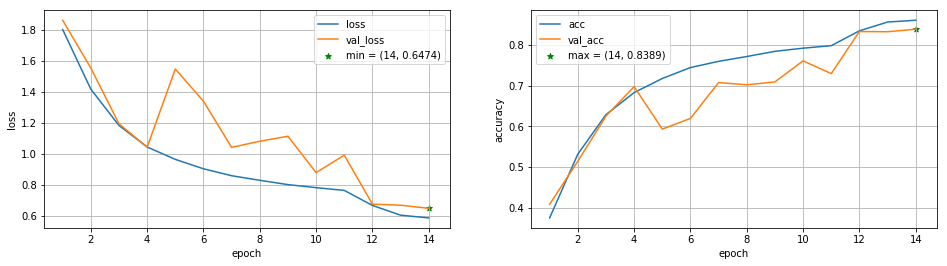

In [13]:
#plot what happened during training
plot_history(history, gen=True)

# Score trained model on training and test set
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train accuracy:', scores[1])
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#confusion matrix
y_test1 = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test, batch_size=batch_size), axis=1)
conf_matrix = confusion_matrix(y_test1, y_pred)
print(conf_matrix.transpose())

## Findings for Part 1: The baseline with 5000 training examples of each class has 84% test accuracy and 87% train accuracy.

## Part 2: Synthesise training imbalance and compare with baseline, using a *balanced* test set

In [78]:
## define the imbalance
NumLowClasses = 5
NumNormalClasses = num_classes-5
Ratio = 10
NumNormalExamples = int(K_train/num_classes)
NumLowExamples = int(NumNormalExamples/Ratio)
K_train_imbalanced = NumLowClasses*NumLowExamples+NumNormalClasses*NumNormalExamples

#get imbalanced training set. Inelegant code, but effective
x_train_imbalanced = np.zeros((K_train_imbalanced,32,32,3),'float32')
y_train_imbalanced = np.zeros(K_train_imbalanced,'uint8')
for i in range(NumLowClasses):
    ThisClass=np.nonzero(y_train_orig == i)
    x_train_imbalanced[i*NumLowExamples:(i+1)*NumLowExamples,:,:,:] = x_train[ThisClass[0][0:NumLowExamples],:,:,:]
    y_train_imbalanced[i*NumLowExamples:(i+1)*NumLowExamples]=i
for i in range(NumNormalClasses):
    ThisClass=np.nonzero(y_train_orig == i+NumLowClasses)
    x_train_imbalanced[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples,:,:,:] = x_train[ThisClass[0][0:NumNormalExamples],:,:,:]
    y_train_imbalanced[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples]=i+NumLowClasses

# Convert class vectors to one-hot labelled categorical matrices.
y_train_imbalanced_orig = deepcopy(y_train_imbalanced)
y_train_imbalanced = keras.utils.to_categorical(y_train_imbalanced, num_classes)

In [35]:
#recompile the model and train
model_imbalanced = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

model_imbalanced.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])


history_imbalanced = model_imbalanced.fit_generator(datagen.flow(x_train_imbalanced, y_train_imbalanced, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
220/220 [==============================] - 23s 104ms/step - loss: 1.4366 - acc: 0.5550 - val_loss: 2.3525 - val_acc: 0.3364
Epoch 2/14
Learning rate:  0.1
220/220 [==============================] - 16s 73ms/step - loss: 1.0879 - acc: 0.6878 - val_loss: 2.4478 - val_acc: 0.3259
Epoch 3/14
Learning rate:  0.1
220/220 [==============================] - 16s 73ms/step - loss: 0.9453 - acc: 0.7340 - val_loss: 1.9508 - val_acc: 0.4383
Epoch 4/14
Learning rate:  0.1
220/220 [==============================] - 15s 66ms/step - loss: 0.8451 - acc: 0.7679 - val_loss: 3.6017 - val_acc: 0.2804
Epoch 5/14
Learning rate:  0.1
220/220 [==============================] - 12s 55ms/step - loss: 0.7872 - acc: 0.7873 - val_loss: 1.9227 - val_acc: 0.4875
Epoch 6/14
Learning rate:  0.1
220/220 [==============================] - 15s 70ms/step - loss: 0.7325 - acc: 0.8088 - val_loss: 1.9237 - val_acc: 0.5238
Epoch 7/14
Learning rate:  0.1
220/220 [==============================] - 1

27500/27500 [==============================] - 7s 267us/step
Train accuracy: 0.8910545454545454
10000/10000 [==============================] - 3s 260us/step
Test accuracy: 0.6667
[[615   3  51   9  21   0   0   2  14   2]
 [ 12 775   1   2   1   0   0   1   7  15]
 [ 24   0 254  12  13   5   3   0   0   0]
 [  2   0   2  73   8   4   0   0   0   0]
 [  5   0  44  15 399   7   1  11   0   2]
 [ 20   2 133 345  50 803   9  30   2   2]
 [ 56  21 383 404 341  97 976  30  16  14]
 [ 38   1  77  78 147  70   4 908   5   6]
 [138  27  34  28  14   4   6   3 919  14]
 [ 90 171  21  34   6  10   1  15  37 945]]


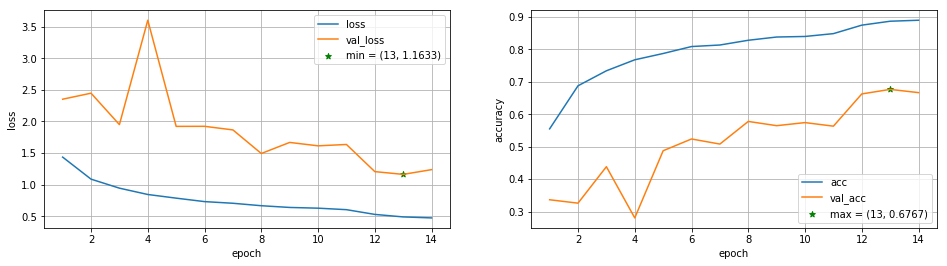

In [68]:
#plot what happened during training
plot_history(history_imbalanced, gen=True)

# Score trained model on training and test set
scores = model_imbalanced.evaluate(x_train_imbalanced, y_train_imbalanced, verbose=1)
print('Train accuracy:', scores[1])
scores = model_imbalanced.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#confusion matrix
y_pred = np.argmax(model_imbalanced.predict(x_test, batch_size=batch_size), axis=1)
conf_matrix = confusion_matrix(y_test1, y_pred)
print(conf_matrix.transpose())

## Findings for Part 2: The confusion matrix shows that the classes with fewer examples have been harder to learn.
## Test accuracy = 67%. Training accuracy = 89%

## So much more overfitting: fewer training samples overall

## Also note: "accuracy" for train is misleading, since many more examples in classes 5-9

## Part 3: Create a fair comparison: balanced, but reduced training samples

In [46]:
## define the imbalance
NumLowClasses = 0
NumNormalClasses = num_classes
NumNormalExamples = int(K_train_imbalanced/num_classes)
NumLowExamples = 0
K_train_fair = NumLowClasses*NumLowExamples+NumNormalClasses*NumNormalExamples

#get imbalanced training set. Inelegant code, but effective
x_train_fair = np.zeros((K_train_fair,32,32,3),'float32')
y_train_fair = np.zeros(K_train_fair,'uint8')
for i in range(NumNormalClasses):
    ThisClass=np.nonzero(y_train_orig == i+NumLowClasses)
    x_train_fair[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples,:,:,:] = x_train[ThisClass[0][0:NumNormalExamples],:,:,:]
    y_train_fair[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples]=i+NumLowClasses

# Convert class vectors to one-hot labelled categorical matrices.
y_train_fair = keras.utils.to_categorical(y_train_fair, num_classes)


In [47]:
#recompile the model and train
model_fair = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

model_fair.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

history_fair = model_fair.fit_generator(datagen.flow(x_train_fair, y_train_fair, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
220/220 [==============================] - 21s 94ms/step - loss: 1.9302 - acc: 0.3294 - val_loss: 1.7909 - val_acc: 0.3807
Epoch 2/14
Learning rate:  0.1
220/220 [==============================] - 15s 70ms/step - loss: 1.6406 - acc: 0.4431 - val_loss: 3.2468 - val_acc: 0.2937
Epoch 3/14
Learning rate:  0.1
220/220 [==============================] - 16s 73ms/step - loss: 1.4721 - acc: 0.5167 - val_loss: 1.6009 - val_acc: 0.4887
Epoch 4/14
Learning rate:  0.1
220/220 [==============================] - 17s 76ms/step - loss: 1.3334 - acc: 0.5696 - val_loss: 1.3835 - val_acc: 0.5469
Epoch 5/14
Learning rate:  0.1
220/220 [==============================] - 16s 74ms/step - loss: 1.2274 - acc: 0.6100 - val_loss: 1.5824 - val_acc: 0.5319
Epoch 6/14
Learning rate:  0.1
220/220 [==============================] - 13s 61ms/step - loss: 1.1312 - acc: 0.6502 - val_loss: 1.0823 - val_acc: 0.6712
Epoch 7/14
Learning rate:  0.1
220/220 [==============================] - 12

27500/27500 [==============================] - 7s 258us/step
Train accuracy: 0.8327272727359425
10000/10000 [==============================] - 3s 260us/step
Test accuracy: 0.8007
[[826   7  62  27  14  10   5  13  36  18]
 [ 16 944   4   7   3   2   1   4  20  84]
 [ 52   1 657  49  49  39  25  19   4   3]
 [ 11   0  30 571  29 111  18  23   3   3]
 [ 11   0  53  48 765  35   7  32   5   2]
 [  1   1  47 124  19 695   9  25   1   5]
 [ 10   6 105 101  80  40 924  15   8   5]
 [  7   0  23  42  36  57   7 861   3   7]
 [ 43   8  10   9   4   7   3   3 907  16]
 [ 23  33   9  22   1   4   1   5  13 857]]


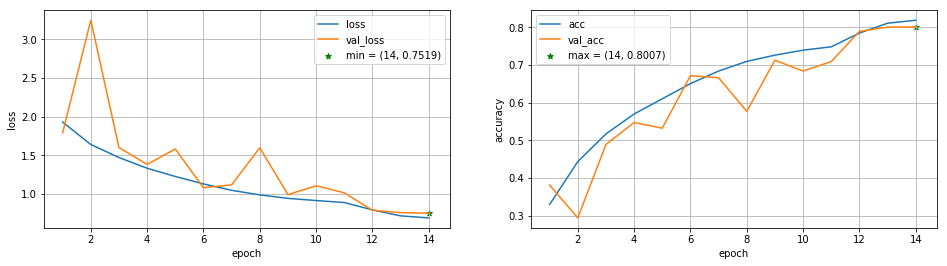

In [69]:
#plot what happened during training
plot_history(history_fair, gen=True)

# Score trained model on training and test set
scores = model_fair.evaluate(x_train_fair, y_train_fair, verbose=1)
print('Train accuracy:', scores[1])
scores = model_fair.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#confusion matrix
y_pred = np.argmax(model_fair.predict(x_test, batch_size=batch_size), axis=1)
conf_matrix = confusion_matrix(y_test1, y_pred)
print(conf_matrix.transpose())

## Findings for Part 3: Test accuracy = 80% and Train accuracy = 83%. Better balance in training results in less overfitting. But fewer samples per class reduces test accuracy as expected.

## Part 4: Use minority-class oversampling

In [51]:
#To make it very explicit, rather than create a custom generator, I instead simply again revise the training set, 
#by restoring its size to 50000, by making 10 copies of each of the first 500 samples in the first 5 classes.

# define the imbalance
NumLowClasses = 5
NumNormalClasses = num_classes-5
Ratio = 10
NumNormalExamples = int(K_train/num_classes)
NumLowExamples = int(NumNormalExamples/Ratio)
OversamplingFactor = Ratio

K_train_oversampling = OversamplingFactor*NumLowClasses*NumLowExamples+NumNormalClasses*NumNormalExamples

#get imbalanced training set. Inelegant code, but effective
x_train_oversampling = np.zeros((K_train_oversampling,32,32,3),'float32')
y_train_oversampling = np.zeros(K_train_oversampling,'uint8')
for i in range(NumLowClasses):
    ThisClass=np.nonzero(y_train_orig == i)
    #do the oversampling for minority classes
    for j in range(OversamplingFactor):
        x_train_oversampling[i*NumNormalExamples+j*NumLowExamples:i*NumNormalExamples+(j+1)*NumLowExamples,:,:,:] = x_train[ThisClass[0][0:NumLowExamples],:,:,:]
    y_train_oversampling[i*NumNormalExamples:(i+1)*NumNormalExamples]=i
for i in range(NumNormalClasses):
    ThisClass=np.nonzero(y_train_orig == i+NumLowClasses)
    x_train_oversampling[NumLowClasses*NumNormalExamples+i*NumNormalExamples:NumLowClasses*NumNormalExamples+(i+1)*NumNormalExamples,:,:,:] = x_train[ThisClass[0][0:NumNormalExamples],:,:,:]
    y_train_oversampling[NumLowClasses*NumNormalExamples+i*NumNormalExamples:NumLowClasses*NumNormalExamples+(i+1)*NumNormalExamples]=i+NumLowClasses

# Convert class vectors to one-hot labelled categorical matrices.
y_train_oversampling = keras.utils.to_categorical(y_train_oversampling, num_classes)

In [53]:
#recompile the model and train
model_oversampling = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

model_oversampling.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

history_oversampling = model_oversampling.fit_generator(datagen.flow(x_train_oversampling, y_train_oversampling, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
400/400 [==============================] - 33s 82ms/step - loss: 1.7677 - acc: 0.3851 - val_loss: 1.7469 - val_acc: 0.4369
Epoch 2/14
Learning rate:  0.1
400/400 [==============================] - 23s 58ms/step - loss: 1.3362 - acc: 0.5633 - val_loss: 1.5379 - val_acc: 0.5240
Epoch 3/14
Learning rate:  0.1
400/400 [==============================] - 25s 63ms/step - loss: 1.0957 - acc: 0.6638 - val_loss: 1.1942 - val_acc: 0.6415
Epoch 4/14
Learning rate:  0.1
400/400 [==============================] - 20s 50ms/step - loss: 0.9524 - acc: 0.7241 - val_loss: 1.2619 - val_acc: 0.6397
Epoch 5/14
Learning rate:  0.1
400/400 [==============================] - 26s 64ms/step - loss: 0.8526 - acc: 0.7630 - val_loss: 1.0419 - val_acc: 0.7100
Epoch 6/14
Learning rate:  0.1
400/400 [==============================] - 22s 56ms/step - loss: 0.7784 - acc: 0.7920 - val_loss: 1.0504 - val_acc: 0.7217
Epoch 7/14
Learning rate:  0.1
400/400 [==============================] - 24

50000/50000 [==============================] - 14s 275us/step
Train accuracy: 0.95064
10000/10000 [==============================] - 3s 303us/step
Test accuracy: 0.7856
[[762   3  56  29  25   4   5   5  21   7]
 [ 18 901   3  11   4   3   1   4  10  35]
 [ 46   1 610  37  47  22  12  13   2   1]
 [  9   1  19 428  29  46   8   9   1   2]
 [ 11   0  49  31 673  27   3  22   2   1]
 [  3   1  63 195  37 786  10  32   2   1]
 [ 16   5 152 187 118  59 954  19   6   7]
 [ 12   2  24  40  57  36   4 882   3   4]
 [ 82  20  13  16   6   7   3   5 930  12]
 [ 41  66  11  26   4  10   0   9  23 930]]


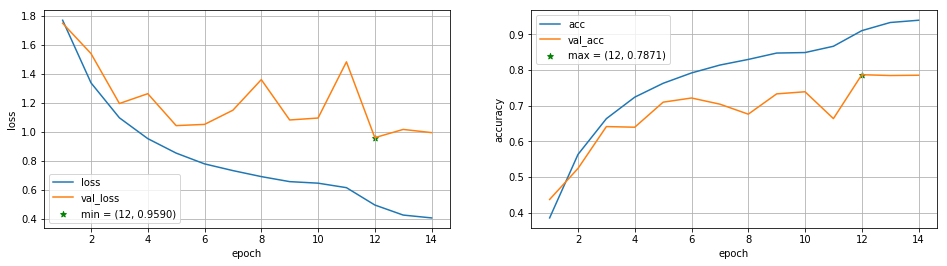

In [57]:
#plot what happened during training
plot_history(history_oversampling, gen=True)

# Score trained model on training and test set
scores = model_oversampling.evaluate(x_train_oversampling, y_train_oversampling, verbose=1)
print('Train accuracy:', scores[1])
scores = model_oversampling.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#confusion matrix
y_pred = np.argmax(model_oversampling.predict(x_test, batch_size=batch_size), axis=1)
conf_matrix = confusion_matrix(y_test1, y_pred)
print(conf_matrix.transpose())

## Findings for Part 4: Oversampling improves test accuracy from 67% to 79%. Less overfitting now: train accuracy has increased from 89% to 95% (gap of 22% reduced to 6%)


## Almost matches the fair-comparison baseline of 80% test accuracy, but still have much more overfitting in comparison to that.

In [61]:
#Part 5: Majority class undersampling
## define the imbalance
NumLowClasses = 0
NumNormalClasses = num_classes
NumNormalExamples = 500
NumLowExamples = 0
K_train_undersampling = NumLowClasses*NumLowExamples+NumNormalClasses*NumNormalExamples

#get imbalanced training set. Inelegant code, but effective
x_train_undersampling = np.zeros((K_train_undersampling,32,32,3),'float32')
y_train_undersampling = np.zeros(K_train_undersampling,'uint8')
for i in range(NumNormalClasses):
    ThisClass=np.nonzero(y_train_orig == i+NumLowClasses)
    x_train_undersampling[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples,:,:,:] = x_train[ThisClass[0][0:NumNormalExamples],:,:,:]
    y_train_undersampling[NumLowClasses*NumLowExamples+i*NumNormalExamples:NumLowClasses*NumLowExamples+(i+1)*NumNormalExamples]=i+NumLowClasses

# Convert class vectors to one-hot labelled categorical matrices.
y_train_undersampling = keras.utils.to_categorical(y_train_undersampling, num_classes)


In [62]:
#recompile the model and train
model_undersampling = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

model_undersampling.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])

history_undersampling = model_undersampling.fit_generator(datagen.flow(x_train_undersampling, y_train_undersampling, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks)

Epoch 1/14
Learning rate:  0.1
40/40 [==============================] - 13s 337ms/step - loss: 2.1569 - acc: 0.2222 - val_loss: 2.9547 - val_acc: 0.1868
Epoch 2/14
Learning rate:  0.1
40/40 [==============================] - 3s 66ms/step - loss: 1.9592 - acc: 0.2996 - val_loss: 2.0623 - val_acc: 0.2827
Epoch 3/14
Learning rate:  0.1
40/40 [==============================] - 3s 73ms/step - loss: 1.8790 - acc: 0.3342 - val_loss: 2.0810 - val_acc: 0.2806
Epoch 4/14
Learning rate:  0.1
40/40 [==============================] - 3s 77ms/step - loss: 1.8436 - acc: 0.3532 - val_loss: 1.8174 - val_acc: 0.3516
Epoch 5/14
Learning rate:  0.1
40/40 [==============================] - 3s 70ms/step - loss: 1.7976 - acc: 0.3782 - val_loss: 1.8822 - val_acc: 0.3485
Epoch 6/14
Learning rate:  0.1
40/40 [==============================] - 3s 71ms/step - loss: 1.7662 - acc: 0.3766 - val_loss: 1.7701 - val_acc: 0.3853
Epoch 7/14
Learning rate:  0.1
40/40 [==============================] - 3s 73ms/step - loss:

5000/5000 [==============================] - 1s 258us/step
Train accuracy: 0.5516
10000/10000 [==============================] - 3s 275us/step
Test accuracy: 0.5126
[[510  16  90  20  34   8   6  10 146  31]
 [ 75 720  22  20  15  12  30   7 127 142]
 [ 59   3 346  68 162  79  68  14  16   4]
 [ 32  12 105 311  78 200  90  67  18  15]
 [  4   1  97  36 276  44  54  47   4   2]
 [  9  15 108 194  55 421  26 117   7  14]
 [ 23  26 129 201 198  94 681  34   9  36]
 [ 27   5  54  81 156 102  14 617  18  21]
 [154  19  22   8   8   7   1   3 531  22]
 [107 183  27  61  18  33  30  84 124 713]]


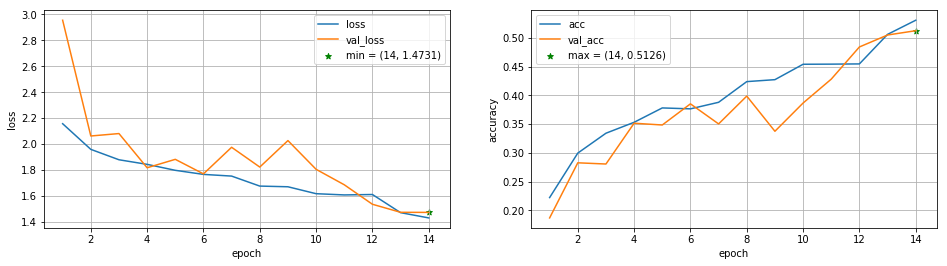

In [64]:
#plot what happened during training
plot_history(history_undersampling, gen=True)

# Score trained model on training and test set
scores = model_undersampling.evaluate(x_train_undersampling, y_train_undersampling, verbose=1)
print('Train accuracy:', scores[1])
scores = model_undersampling.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

#confusion model_undersampling
y_pred = np.argmax(model_undersampling.predict(x_test, batch_size=batch_size), axis=1)
conf_matrix = confusion_matrix(y_test1, y_pred)
print(conf_matrix.transpose())

# Findings for Part 5: Undersampling the majority class gives test accuracy 51% and train accuracy 55% - not good! (but not surprising, since we know CIFAR is hard))

In [ ]:
##Part 6: try to use class weights on the Part 2 data

In [90]:
my_class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_imbalanced_orig),
                                                 y_train_imbalanced_orig)
print(my_class_weight)

[5.5  5.5  5.5  5.5  5.5  0.55 0.55 0.55 0.55 0.55]


In [83]:
#recompile the model and train
model_imbalanced_class_weights = allconvnet(input_shape=input_shape,
                   num_classes=num_classes,
                   base_filters=base_filters,
                   num_scales=num_scales,
                   blocks_per_scale=blocks_per_scale,
                   bn_moments_momentum=bn_moments_momentum,
                   My_wd=my_weight_decay)

model_imbalanced_class_weights.compile(loss='categorical_crossentropy',
              optimizer =SGD(lr=0.1,decay=0, momentum=0.9, nesterov=False),
              metrics=['accuracy'])


history_imbalanced_class_weights = model_imbalanced_class_weights.fit_generator(datagen.flow(x_train_imbalanced, y_train_imbalanced, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              workers=1,
                              callbacks=callbacks,
                              class_weight=my_class_weight) #new input param

Epoch 1/14
Learning rate:  0.1
220/220 [==============================] - 24s 109ms/step - loss: 1.5019 - acc: 0.5286 - val_loss: 2.5598 - val_acc: 0.3166
Epoch 2/14
Learning rate:  0.1
220/220 [==============================] - 16s 72ms/step - loss: 1.2095 - acc: 0.6455 - val_loss: 2.1819 - val_acc: 0.3650
Epoch 3/14
Learning rate:  0.1
220/220 [==============================] - 15s 68ms/step - loss: 1.0455 - acc: 0.7036 - val_loss: 2.1104 - val_acc: 0.3709
Epoch 4/14
Learning rate:  0.1
220/220 [==============================] - 12s 53ms/step - loss: 0.9360 - acc: 0.7384 - val_loss: 1.9531 - val_acc: 0.4561
Epoch 5/14
Learning rate:  0.1
220/220 [==============================] - 16s 73ms/step - loss: 0.8419 - acc: 0.7706 - val_loss: 1.6554 - val_acc: 0.5027
Epoch 6/14
Learning rate:  0.1
220/220 [==============================] - 15s 67ms/step - loss: 0.7849 - acc: 0.7876 - val_loss: 1.7195 - val_acc: 0.5020
Epoch 7/14
Learning rate:  0.1
220/220 [==============================] - 1

## No difference to Part 2! Maybe a keras bug? Stack-exchange suggests so... but also some fixed. Homework!